In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import scipy.io as sio
import numpy as np
import os
import glob
from time import time
import math
from torch.nn import init
import copy
import cv2
import matplotlib.pyplot as plt
from utils.ISTANet import *
try:
    from skimage.metrics import structural_similarity as ssim
except ImportError:
    from skimage.measure import compare_ssim as ssim
from argparse import ArgumentParser
import types

import torchvision.transforms as transforms

/home/polina/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Test set parameters:
epoch_num = 100 #Which model to test on
cs_ratio = 50 #Which compression ratio to use 10 vs 50
noise_sigma = 0.05#0.05 #Test and noise at the level

#Model parameters
model_dir = "./models" #Where the model from the training set is stored:
layer_num = 25
group_num = 1
matrix_dir = 'sampling_matrix'
test_dir = "data"



In [3]:
#System configuration
try:
    # The flag below controls whether to allow TF32 on matmul. This flag defaults to True.
    torch.backends.cuda.matmul.allow_tf32 = False
    # The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
    torch.backends.cudnn.allow_tf32 = False
except:
    pass

#Select device (CPU/GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:"+str(device))

Device:cuda:0


In [4]:
# Load CS Sampling 
Phi_data_Name = './%s/mask_%d.mat' % (matrix_dir, cs_ratio)
Phi_data = sio.loadmat(Phi_data_Name)
mask_matrix = Phi_data['mask_matrix']

mask_matrix = torch.from_numpy(mask_matrix).type(torch.FloatTensor)
mask = torch.unsqueeze(mask_matrix, 2)
mask = torch.cat([mask, mask], 2)
mask = mask.to(device)

## Test

In [5]:
##Load data
from torch.utils.data import Dataset, DataLoader
class RandomDataset(Dataset):
    def __init__(self, data, length,transform=None):
        self.data = data
        self.len = length
        self.transform = transform

    def __getitem__(self, index):
        item = torch.unsqueeze(torch.Tensor(self.data[index, :]).float(),0)
        if self.transform:
            #print(np.shape(item))
            item = self.transform(item)

        return item
    
    def __len__(self):
        return self.len

    
def normalize91():
    def _func(img):
        inp = np.asarray(img)
        inp_out = (inp - np.min(inp)) / np.ptp(inp)
        return  inp_out
    return _func
    
    
data_dir = "data"
Test_data_Name = 'Test_Brain_images.mat' #Test matlab file
Test_data = sio.loadmat('./%s/%s' % (data_dir, Test_data_Name))
Test_labels = Test_data['labels']

data_transforms = transforms.Compose([
    transforms.CenterCrop(256),
    normalize91() 
])

rand_loader = DataLoader(dataset=RandomDataset(Test_labels, 50,transform=data_transforms), batch_size=1, num_workers=4,
                         shuffle=True)

In [6]:
#Prepare model
model = ISTANetplus(layer_num)
model = nn.DataParallel(model)
model = model.to(device)
# Load pre-trained model with epoch number
model.load_state_dict(torch.load('./%s/net_params_cs_%d_%d.pkl' % (model_dir,cs_ratio,epoch_num)))

<All keys matched successfully>

Processing test data.... it might take a while
MSE from: 0.0024783441 to 0.0010481651
SSIM from: 0.4569416652759563 to 0.6520401627685242
SNR from: 10.140573978424072 to 13.877893686294556


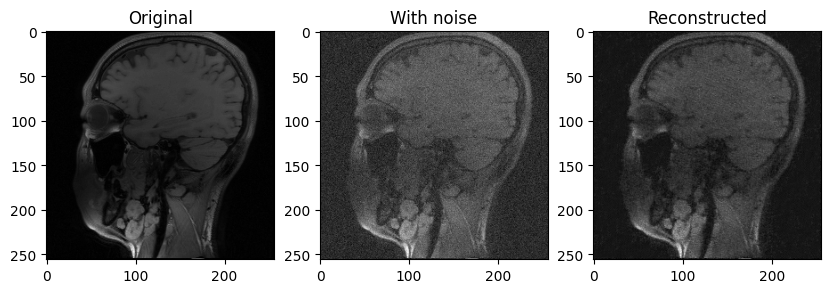

MSE from: 0.0024943498 to 0.0014197117
SSIM from: 0.4855823038132121 to 0.6959022230010032
SNR from: 14.446185827255249 to 16.893757581710815


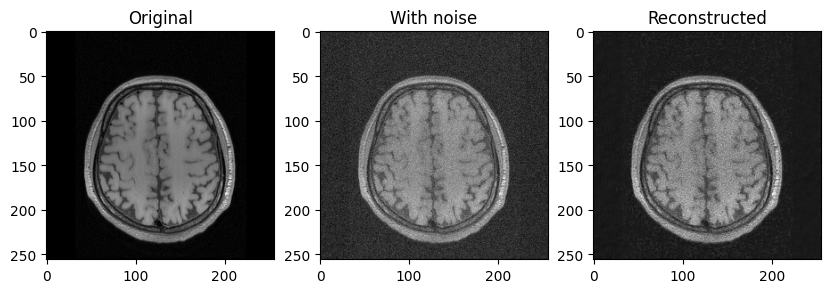

MSE from: 0.0024924907 to 0.0016532753
SSIM from: 0.5138551811325699 to 0.6916323211509288
SNR from: 16.114530563354492 to 17.897415161132812


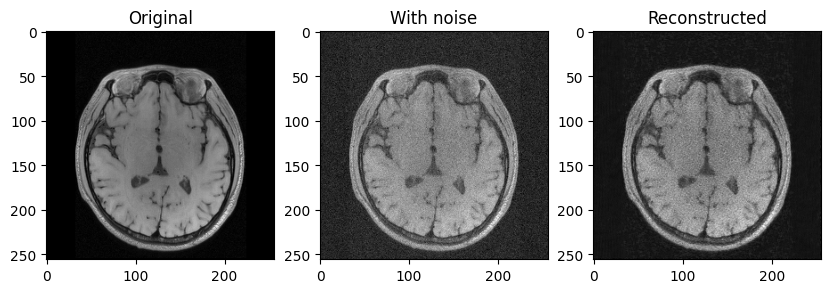

MSE from: 0.0024974456 to 0.00080114556
SSIM from: 0.3505803972513592 to 0.6286084725815403
SNR from: 6.537380814552307 to 11.475226879119873


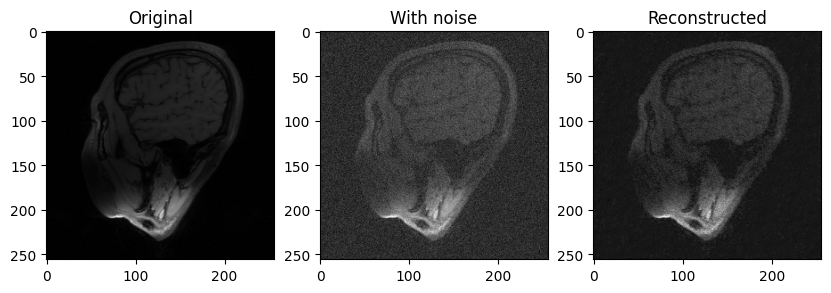

MSE from: 0.0024952434 to 0.0010487989
SSIM from: 0.45259663522706556 to 0.6427919772070217
SNR from: 10.091073513031006 to 13.855280876159668


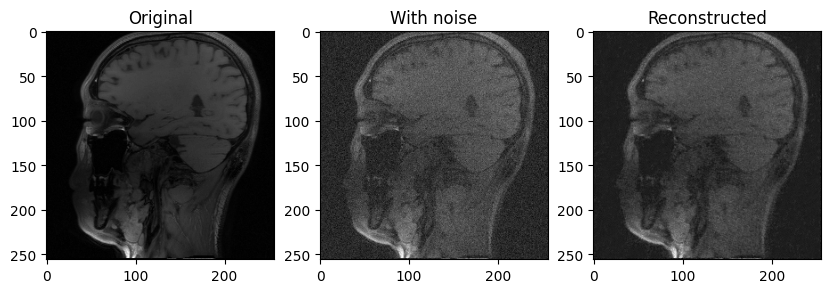

MSE from: 0.002491389 to 0.0012049868
SSIM from: 0.4362761654415961 to 0.6583139311479107
SNR from: 12.868956327438354 to 16.02354884147644


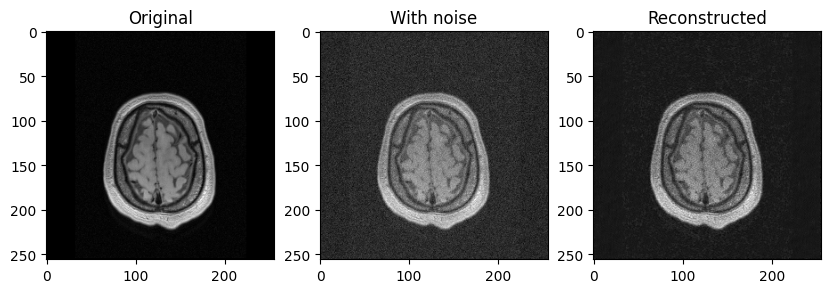

MSE from: 0.0024701492 to 0.0016243242
SSIM from: 0.6527808285628259 to 0.7358127422439456
SNR from: 14.613797664642334 to 16.43430233001709


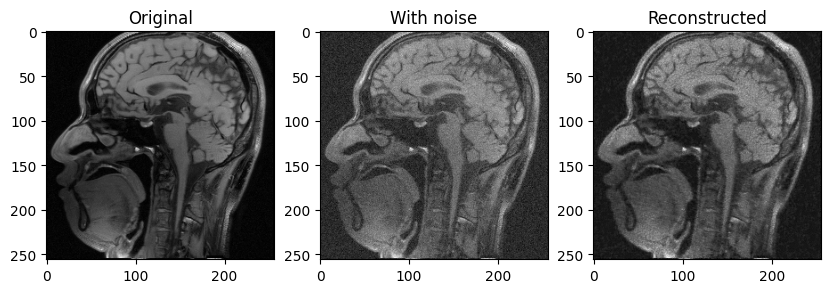

MSE from: 0.0024905484 to 0.00064051745
SSIM from: 0.2977030494122092 to 0.6192465581692029
SNR from: 3.4165984392166138 to 9.314239025115967


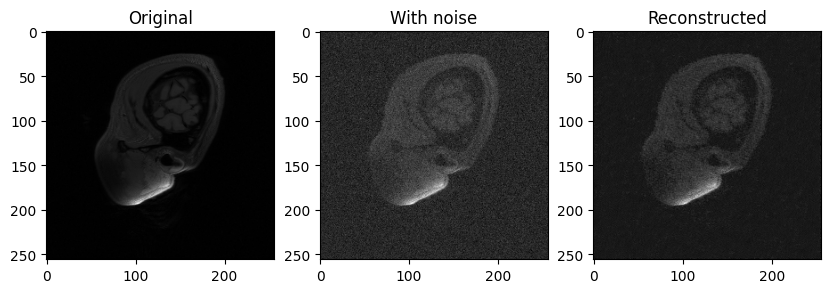

MSE from: 0.002495484 to 0.0014276349
SSIM from: 0.463813008776255 to 0.6697849662965462
SNR from: 14.474719762802124 to 16.90009593963623


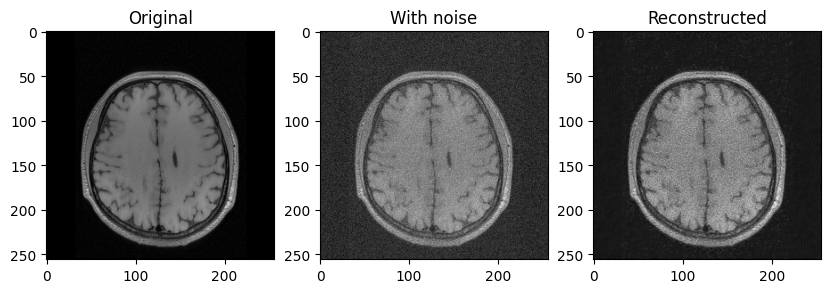

MSE from: 0.0024867181 to 0.0017697541
SSIM from: 0.6546378025018033 to 0.7238117262128592
SNR from: 15.9534752368927 to 17.430611848831177


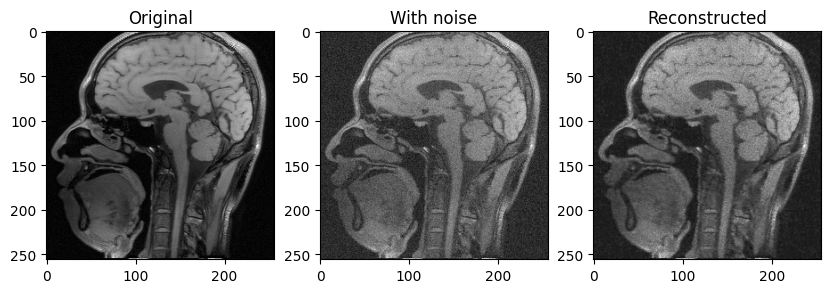

MSE from: 0.0024897323 to 0.0015268439
SSIM from: 0.48456914762163256 to 0.6818266447384571
SNR from: 15.517804622650146 to 17.641385793685913


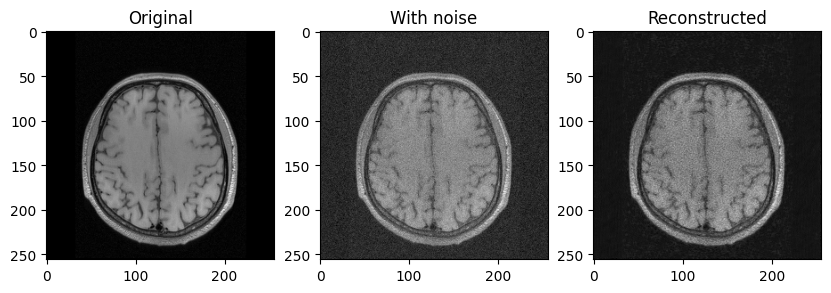

MSE from: 0.0024757248 to 0.0014825534
SSIM from: 0.48605554149794766 to 0.6830868949795067
SNR from: 15.189834833145142 to 17.416754961013794


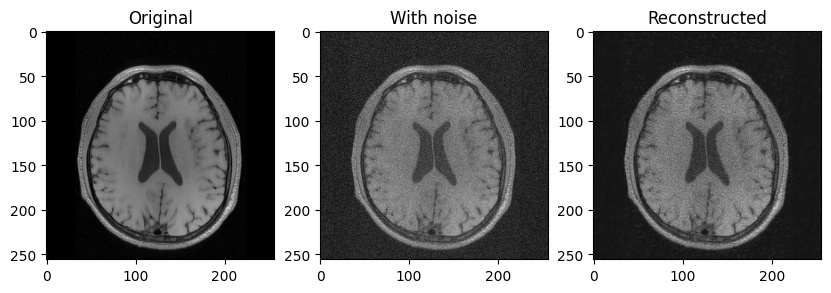

MSE from: 0.0024878085 to 0.001029759
SSIM from: 0.4438818920142008 to 0.6352048111336678
SNR from: 9.778765439987183 to 13.609578609466553


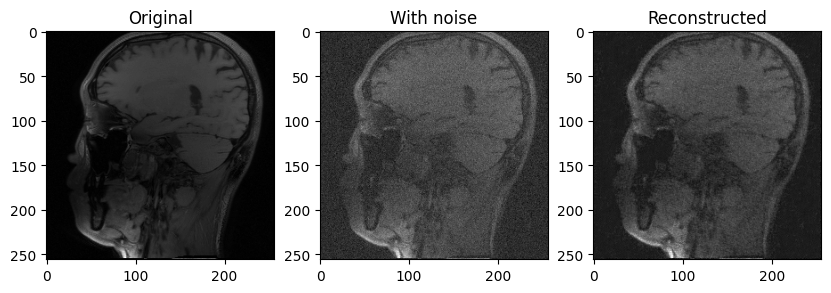

MSE from: 0.0024940567 to 0.0016328915
SSIM from: 0.5467740857323184 to 0.7239696416275502
SNR from: 16.414642333984375 to 18.25413227081299


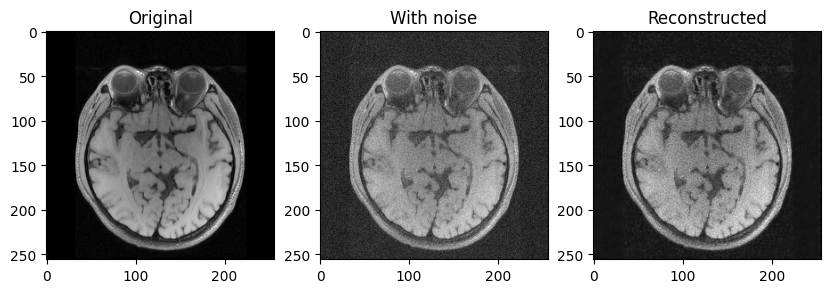

MSE from: 0.002500964 to 0.000988839
SSIM from: 0.4368253720675602 to 0.6557204961445278
SNR from: 9.187180399894714 to 13.216999769210815


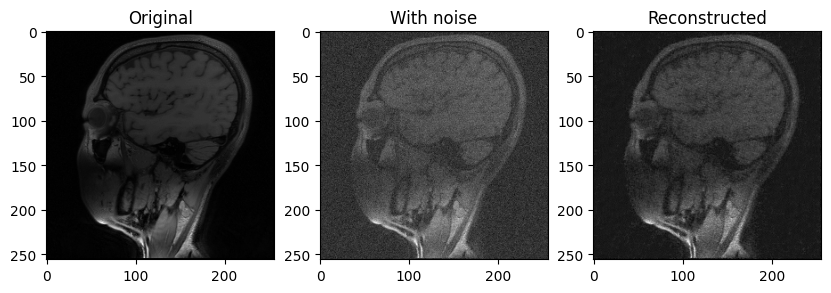

MSE from: 0.0025055497 to 0.0010335192
SSIM from: 0.3958829278653562 to 0.6338030284135491
SNR from: 10.963281393051147 to 14.809126853942871


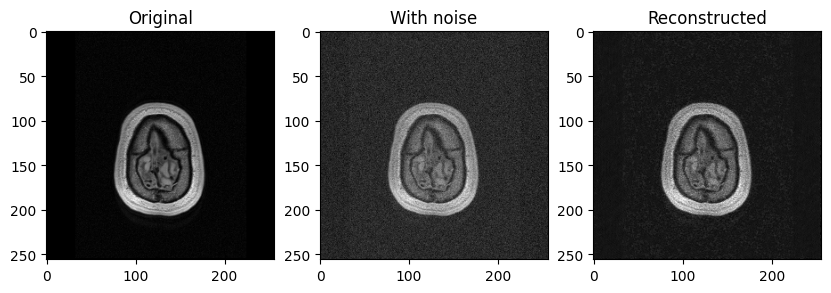

MSE from: 0.0024868252 to 0.0016531658
SSIM from: 0.6137733583789002 to 0.696902437020883
SNR from: 15.141351222991943 to 16.914639472961426


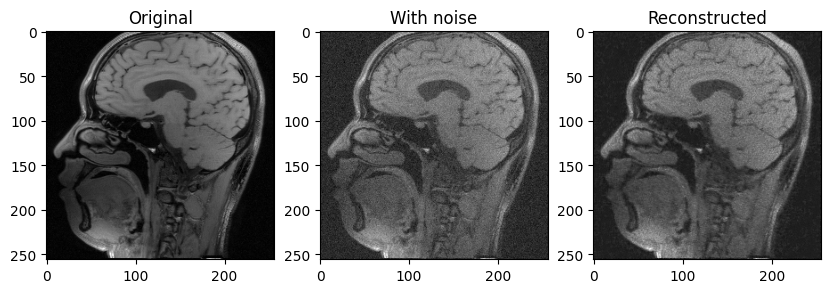

MSE from: 0.0024987867 to 0.00092990586
SSIM from: 0.40287608346974796 to 0.6425798609707696
SNR from: 8.216121792793274 to 12.509022951126099


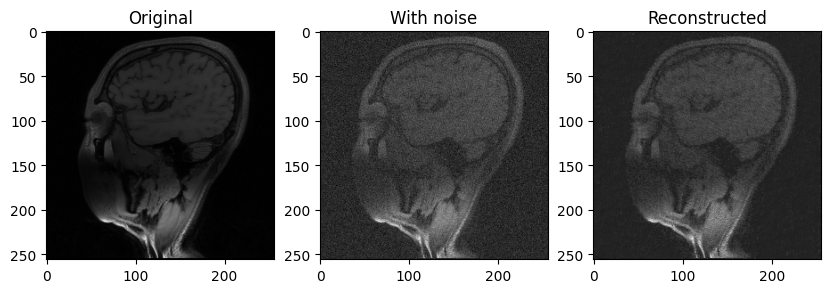

MSE from: 0.002527545 to 0.0012563893
SSIM from: 0.5128302915673875 to 0.6582346221960187
SNR from: 12.493091821670532 to 15.528838634490967


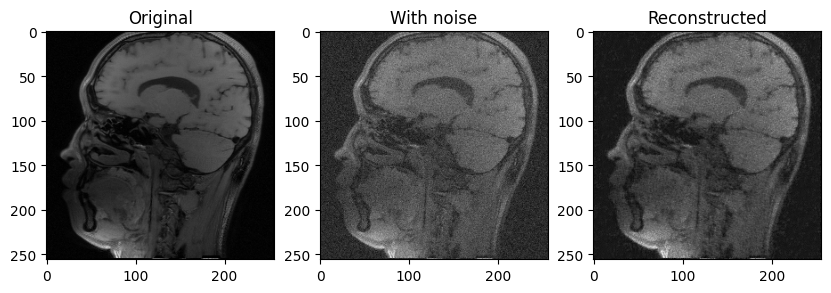

MSE from: 0.0025224932 to 0.0016954816
SSIM from: 0.5423996965974365 to 0.7143539711061939
SNR from: 16.826467514038086 to 18.55183720588684


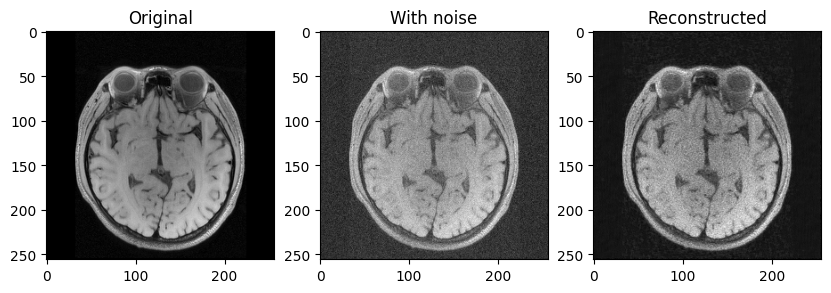

MSE from: 0.0024904646 to 0.0015176616
SSIM from: 0.5029793851114325 to 0.696755288058117
SNR from: 15.32175064086914 to 17.47280478477478


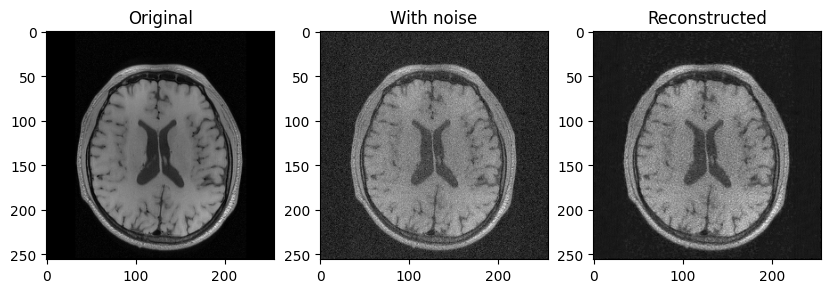

MSE from: 0.002495938 to 0.0017200196
SSIM from: 0.6479768341364804 to 0.7200754190883637
SNR from: 15.227959156036377 to 16.84496283531189


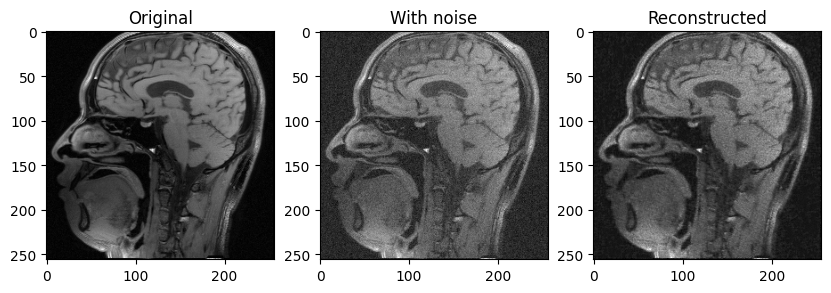

MSE from: 0.0024949026 to 0.0006686404
SSIM from: 0.3092623856106957 to 0.6216689861038532
SNR from: 4.2876386642456055 to 10.006248950958252


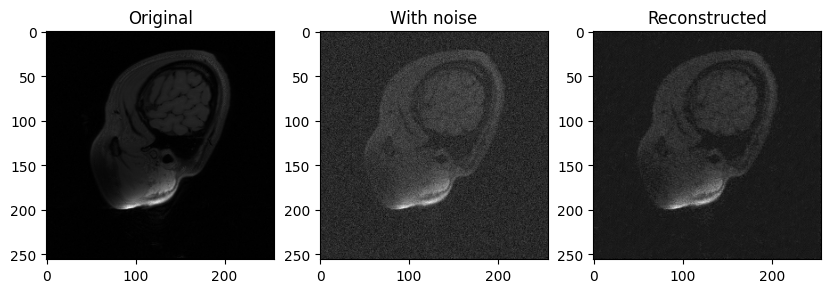

MSE from: 0.0024936474 to 0.0011008091
SSIM from: 0.4704237549862891 to 0.6450084569250867
SNR from: 10.781221389770508 to 14.332451820373535


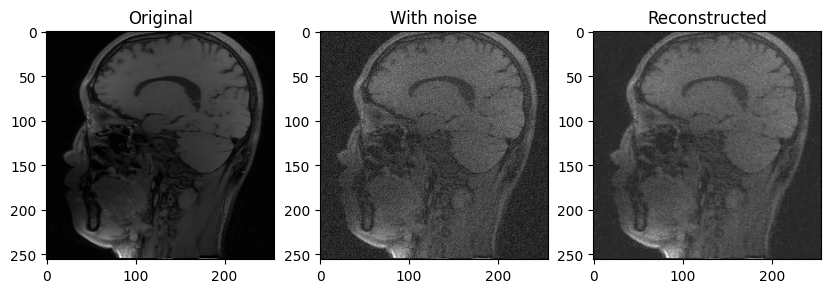

MSE from: 0.0024933552 to 0.0013717543
SSIM from: 0.4742030120822601 to 0.6884284467646181
SNR from: 14.044363498687744 to 16.63944125175476


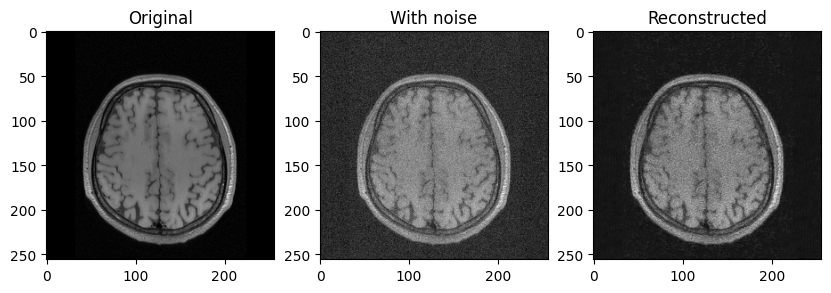

MSE from: 0.00252361 to 0.0014462756
SSIM from: 0.48208868283499956 to 0.689303019109957
SNR from: 14.834439754486084 to 17.252150774002075


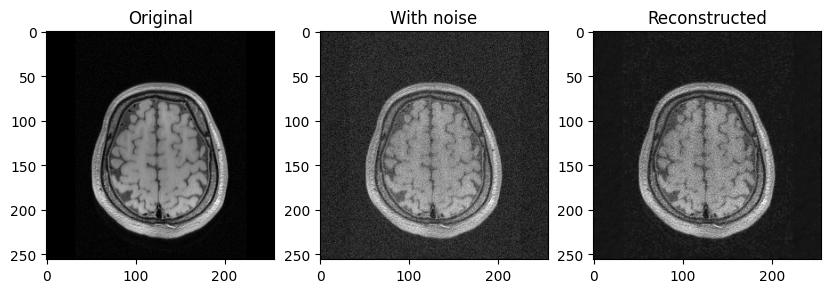

MSE from: 0.0024666518 to 0.0014093234
SSIM from: 0.560931768605873 to 0.6772860976445637
SNR from: 13.720095157623291 to 16.15106701850891


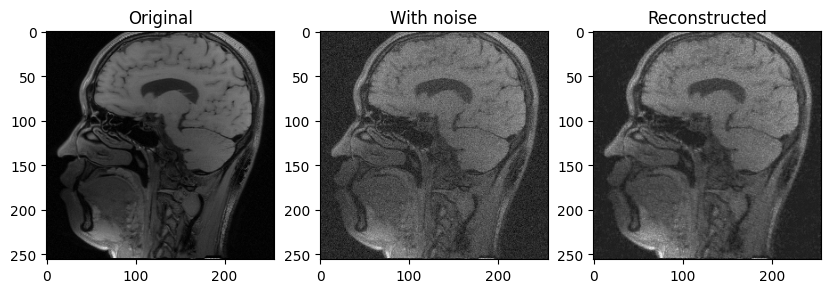

MSE from: 0.0025207521 to 0.001037446
SSIM from: 0.4437564857191858 to 0.6477678480670378
SNR from: 9.72779095172882 to 13.583437204360962


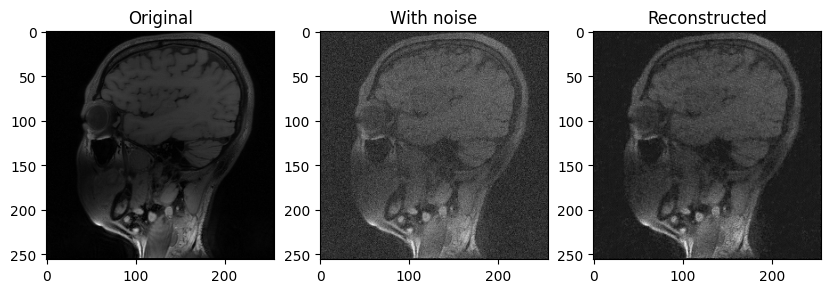

MSE from: 0.0024893493 to 0.0006812062
SSIM from: 0.31167350472811917 to 0.5614938527491531
SNR from: 4.808617830276489 to 10.436689853668213


KeyboardInterrupt: 

In [7]:
# Testing loop
MSE_denoised=[]
MSE_original = []
SSIM_denoised = []
SSIM_original = []

SNR_denoised = []
SNR_original = []

with torch.no_grad():
    print("Processing test data.... it might take a while")
    for data in rand_loader:
        batch_x_orig = data
        batch_x_orig = batch_x_orig.to(device)

        #add noise
        batch_x = (data + noise_sigma*np.random.normal(0,1,np.shape(data))).float()
        batch_x = batch_x.to(device)

        PhiTb = FFT_Mask_ForBack()(batch_x, mask)

        [x_output, _] = model(PhiTb, mask)
        
        
        ##Compute metrics
        batch_x_orig_np = np.squeeze(np.asarray(batch_x_orig.cpu()))
        batch_x_np = np.squeeze(np.asarray(batch_x.detach().cpu()))
        x_output_np = np.squeeze(np.asarray(x_output.detach().cpu()))
                                
        MSE_denoised.append(np.mean(np.power(x_output_np-batch_x_orig_np,2)))
        MSE_original.append(np.mean(np.power(batch_x_np-batch_x_orig_np,2)))
        SNR_denoised.append(10 * np.log10(np.square(batch_x_orig_np).mean()/np.square(x_output_np-batch_x_orig_np).mean()))
        SNR_original.append(10 * np.log10(np.square(batch_x_orig_np).mean()/np.square(batch_x_np-batch_x_orig_np).mean()))
        SSIM_denoised.append(ssim(batch_x_orig_np,x_output_np,data_range=1))
        SSIM_original.append(ssim(batch_x_orig_np,batch_x_np,data_range=1))
        
        print("MSE from: "+str(MSE_original[-1])+" to "+str(MSE_denoised[-1]))
        print("SSIM from: "+str(SSIM_original[-1])+" to "+str(SSIM_denoised[-1]))
        print("SNR from: "+str(SNR_original[-1])+" to "+str(SNR_denoised[-1]))        
        
        #Plot figures
        fig, axs = plt.subplots(1,3)
        fig.set_figheight(10)
        fig.set_figwidth(10)

        cmapstr = "gray" #gray,viridis
        axs[0].imshow(batch_x_orig_np,cmap=cmapstr)
        axs[0].set_title("Original")

        axs[1].imshow(batch_x_np,cmap=cmapstr)
        axs[1].set_title("With noise")

        axs[2].imshow(x_output_np,cmap=cmapstr)
        axs[2].set_title("Reconstructed")
        plt.show()

        
        del x_output
#Compute metrics for the entire dataset
print("Final results")
print("MSE from: "+str(np.mean(MSE_original))+" to "+str(np.mean(MSE_denoised)))
print("SSIM from: "+str(np.mean(SSIM_original))+" to "+str(np.mean(SSIM_denoised)))
print("SNR from: "+str(np.mean(SNR_original))+" to "+str(np.mean(SNR_denoised)))   